# Modelling the absorber distribution

In [1]:
import numpy as np
from scipy.integrate import quad, simps, quadrature, romb, romberg
from scipy.optimize import curve_fit
from scipy import interpolate as interp
from compos import const, matterps as mps, growthfactor as gf
from astropy.units.astrophys import Mpc, M_sun
import astropy.units as u
from pkg_resources import resource_filename
from astropy.constants import G as grav
from astropy.table import Table
from MgIIabs.model import halomassfunc as hmf, halomodel as hmod, absdistrib as ad
import matplotlib.pyplot as plt
import pdb
from scipy.special import ndtr

import cProfile
import time

In order to get $d^2N/dW_rdl$, we need to perform the following integral:
$$
\int_{M_{low}}^{\infty}dM\frac{dN}{dM}\pi R_g^2P(W_r|M)
$$
Where $M_{low}$  is decided by the rest equivalent width we are interested in. It can be obtained from `hmod.lowest_mass`. I have decided to work in units of $10^{12}M_\odot$. Unfortunately, it is very costly computing this integrand (even though there has been around a factor 10 speedup since my original code). 

I have transformed to semi logarithmic space (`y = log10(M)`). This transformation means the integrand gets another factor of $\ln(10)M$. The reason for this is made apparent in the following steps

In [2]:
def integrand(logM_12):
    M = 10**logM_12*1e12
    dndm = hmf.dNdM(M*M_sun,z=z,growthf=growthf)*rho_m/M**2#Because of the way dN/dm is coded
    sigmag = np.pi*hmod.rg(M*M_sun,z=z).value**2
    pWM = hmod.p_rew_given_m(rew,M*M_sun,z=z)[0].value
    return dndm*sigmag*pWM*M

In [3]:
rew = 0.1*u.nm
z = 0
growthf=gf.growfunc_z(z)

M_low = np.log10(hmod.lowest_mass(rew,z=z,low=0).value/1e12) #logarithmic mass in units of 1e12 Msun
M_high = 4

#Cosmological parameters
const.initializecosmo()
H0 = 100*u.km/u.s/u.Mpc #(units of h km/s/Mpc)
rho_cr0 = 3*H0**2/(8*np.pi*grav)
rho_m0 = const.cosmo['omega_0']*rho_cr0
rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3

In [5]:
print(M_low,M_high)
plt.figure()
z = 0
growthf=gf.growfunc_z(z)
for rew in [0.05*u.nm,0.1*u.nm,0.2*u.nm]:
    M_low = np.log10(hmod.lowest_mass(rew,z=z,low=0).value/1e12) #logarithmic mass in units of 1e12 Msun
    M_high = 4
    M12array = np.linspace(M_low-0.01*M_low,M_high,150)
    integ = []
    for mass in M12array:
        integ.append(integrand(mass)*np.log(10))#Bringing in that factor of log(10)
    pdb.set_trace()
    plt.plot(M12array,integ, label="REW = {:1.1f}$\AA$".format(rew.value*10))
plt.legend()
plt.ylabel(r"$\frac{dN}{dM}\pi R_g^2P(W_r|M)M$ $(h^3/Mpc^3)$")
plt.xlabel(r"$\log(M/10^{12} h^{-1}M_\odot)$")
plt.show()

-6.76850906345 4
> <ipython-input-5-6026a6955906>(13)<module>()
-> plt.plot(M12array,integ, label="REW = {:1.1f}$\AA$".format(rew.value*10))
(Pdb) M12array
array([-6.70082397, -6.62900636, -6.55718875, -6.48537114, -6.41355353,
       -6.34173592, -6.26991831, -6.1981007 , -6.12628309, -6.05446548,
       -5.98264787, -5.91083026, -5.83901265, -5.76719504, -5.69537743,
       -5.62355981, -5.5517422 , -5.47992459, -5.40810698, -5.33628937,
       -5.26447176, -5.19265415, -5.12083654, -5.04901893, -4.97720132,
       -4.90538371, -4.8335661 , -4.76174849, -4.68993088, -4.61811327,
       -4.54629566, -4.47447805, -4.40266044, -4.33084282, -4.25902521,
       -4.1872076 , -4.11538999, -4.04357238, -3.97175477, -3.89993716,
       -3.82811955, -3.75630194, -3.68448433, -3.61266672, -3.54084911,
       -3.4690315 , -3.39721389, -3.32539628, -3.25357867, -3.18176106,
       -3.10994345, -3.03812583, -2.96630822, -2.89449061, -2.822673  ,
       -2.75085539, -2.67903778, -2.60722017, -2.535

(Pdb) q


BdbQuit: 

This is a rather wierd shape. Possibly because I'm extraplolating $\kappa_g$. I need to explore this. Interestingly, Tinker and Chen mention some similar shape in Fig 3. There seems to be something off about the amplitude of the function though

### $\kappa_g$

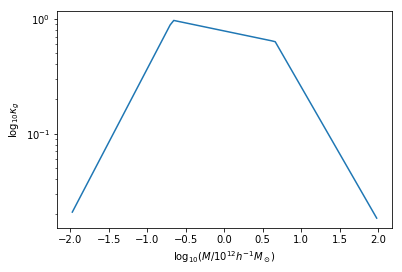

In [8]:
kappagrid = hmod.kappa_g(10**M12array*1e12*M_sun)
plt.figure()
plt.semilogy(M12array,kappagrid)
plt.ylabel("$\log_{10}\kappa_g$")
plt.xlabel("$\log_{10}(M/10^{12} h^{-1}M_\odot$")
plt.show()

## Evaluating the integral

The integrand clearly has breakpoints specified by $\kappa_g$'s vertices. Therefore, it would be prudent to evaluate the integrand in three domains: less than 1e11.33 solMass, between 1e11.33 and 1e12.66 solMass and greater than 1e12.66 solMass. This information needs to be fed to `quad` to perform the integral quickly. I don't need to worry about the lowest mass being below 1e10 solMass because $\kappa_g$ falls rather precipitiously beyond that point. It makes sense to just compute the lowest mass and perform the integration. Similarly, I don't have to worry about masses higher than 1e14 solMass. However, to speed things up, I can choose to truncate the integration by these values.

In [2]:
#Fixing cosmology
import astropy.units as u
from astropy.constants import G as grav, c
from astropy.units.astrophys import Mpc, M_sun
from numpy import pi
from compos import const

const.initializecosmo()
H0 = 100*u.km/u.s/u.Mpc #(units of h km/s/Mpc)
rho_cr0 = 3*H0**2/(8*pi*grav)
rho_m0 = const.cosmo['omega_0']*rho_cr0

In [23]:
#Fixing parameters
rew = 0.1*u.nm
z = 0
rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3
growthf = gf.growfunc_z(z)

M_low = np.log10(hmod.lowest_mass(rew,z=z,low=0).value/1e12) #logarithmic mass in units of 1e12 Msun
M_high = 4

print(M_low,M_high)
integral = np.log(10)*quad(integrand,-2,2,points=[-0.67,0.66])[0]

-4.90262066058 4


In [24]:
integral

0.001326843140025493

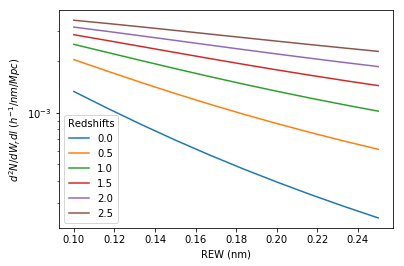

In [30]:
rewlist = np.linspace(0.1,0.25,10)*u.nm
redshifts = np.linspace(0,2.5,6)
plt.figure()
all_integs = []
for z in redshifts:
    rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3
    growthf = gf.growfunc_z(z)
    integlist = []
    for rew in rewlist:
        integlist.append(np.log(10)*quad(integrand,-2,2,points=[-0.67,0.66])[0])
    all_integs.append(integlist)
    plt.semilogy(rewlist,integlist,label="{:1.1f}".format(z))
plt.legend(title="Redshifts")
plt.xlabel("REW (nm)")
plt.ylabel(r"$d^2N/dW_rdl$ ($h^{-1}/nm/Mpc$)")
plt.show()

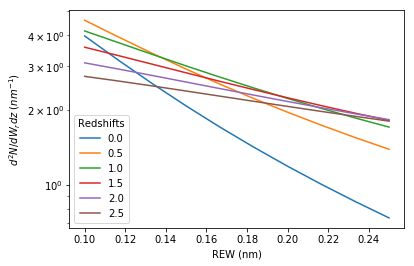

In [8]:
#of course, we can switch from comoving distance to redshift
rewlist = np.linspace(0.1,0.25,10)*u.nm
redshifts = np.linspace(0,2.5,6)
plt.figure()
all_integs = []
for z in redshifts:
    rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3
    growthf = gf.growfunc_z(z)
    integlist = []
    dldz = ad._dldz(z).value
    for rew in rewlist:
        integlist.append(np.log(10)*quad(integrand,-2,2,points=[-0.67,0.66])[0]*dldz)
    all_integs.append(integlist)
    plt.semilogy(rewlist,integlist,label="{:1.1f}".format(z))
plt.legend(title="Redshifts")
plt.xlabel("REW (nm)")
plt.ylabel(r"$d^2N/dW_rdz$ ($nm^{-1}$)")
plt.show()

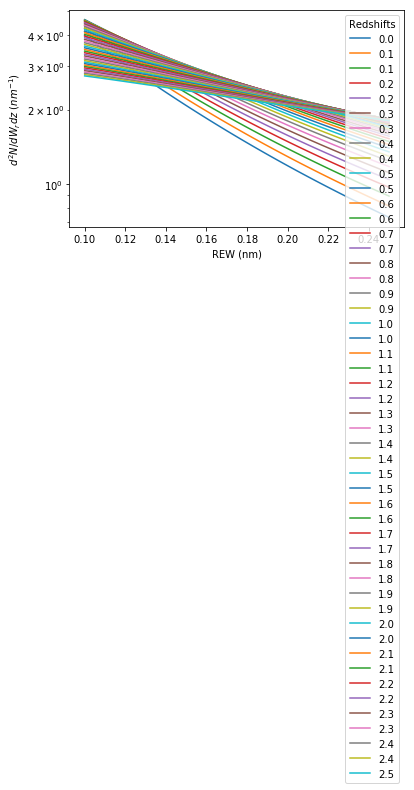

In [28]:
rewlist = np.linspace(0.1,0.25,10)*u.nm
redshifts = np.linspace(0,2.5)
plt.figure()
all_integs = []
for z in redshifts:
    rho_m = rho_m0.to(M_sun/Mpc**3).value*(1+z)**3
    growthf = gf.growfunc_z(z)
    integlist = []
    dldz = ad._dldz(z).value
    for rew in rewlist:
        integlist.append(np.log(10)*quad(integrand,-2,2,points=[-0.67,0.66])[0]*dldz)
    all_integs.append(integlist)
    plt.semilogy(rewlist,integlist,label="{:1.1f}".format(z))
plt.legend(title="Redshifts")
plt.xlabel("REW (nm)")
plt.ylabel(r"$d^2N/dW_rdz$ ($nm^{-1}$)")
plt.show()

In [29]:
dndzdata = np.asarray(all_integs).transpose()
names = [str(z) for z in redshifts]
table = Table(dndzdata,names=names)
table['rew']=rewlist
filename = resource_filename('MgIIabs.count',"")[:-5]+'/data/new_d2ndwdz.csv'
table.write(filename,format="ascii.csv",overwrite=True)

## $dN/dz$

The easist method of obtaining dN/dz is to fit exponnential functions to $d^2N/dW_rdz$ and to use them for integration over REW. So this is what we shall do. Fitting function: $g(z)e^{-W/W*(z)}$

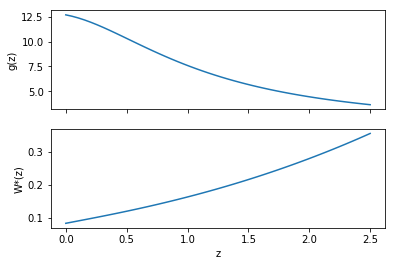

In [36]:
table = Table.read(filename,format="ascii.csv")
model = lambda x,g_z,w_star: g_z*np.exp(-x/w_star)
w_starlist = []
g_zlist = []
p0 = [5,0.14]
for z in redshifts:
    popt, pcov = curve_fit(model,table['rew'],table[str(z)],p0=p0)
    g_zlist.append(popt[0])
    w_starlist.append(popt[1])
fig, axes = plt.subplots(2,1,sharex=True)
axes[0].plot(redshifts,g_zlist)
axes[0].set(ylabel="g(z)")

axes[1].plot(redshifts,w_starlist)
axes[1].set(xlabel="z",ylabel="W*(z)")
plt.show()

In [37]:
#writing to a file for future interpolation
paramtab = Table()
paramtab['z'] = redshifts
paramtab['g'] = g_zlist
paramtab['w'] = w_starlist
filename = resource_filename('MgIIabs.count',"")[:-5]+'/data/params_fndz.csv'
paramtab.write(filename,format="ascii.csv")

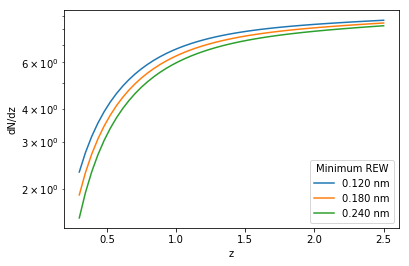

In [5]:
redshifts = np.linspace(0.3,2.5)
rew_min = np.array([0.12,0.18,0.24])*u.nm
plt.figure()
for rew in rew_min:
    dndzarray = [ad.dNdz(z,rew_min) for z in redshifts]
    plt.semilogy(redshifts,dndzarray,label="{:1.3f}".format(rew))
plt.legend(title="Minimum REW")
plt.xlabel("z")
plt.ylabel("dN/dz")
plt.show()

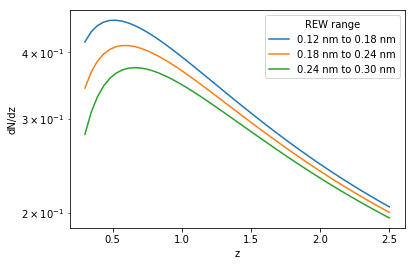

In [2]:
redshifts = np.linspace(0.3,2.5)
rew_min = np.array([0.12,0.18,0.24])*u.nm
rew_max = rew_min+0.06*u.nm
for index, rew in enumerate(rew_min):
    dndzarray = [ad.dNdz(z,rew,rew_max[index]) for z in redshifts]
    plt.semilogy(redshifts,dndzarray,label="{:1.2f} to {:1.2f}".format(rew,rew_max[index]))
plt.legend(title="REW range")
plt.xlabel("z")
plt.ylabel("dN/dz")
plt.show()

We can compare it against Zhu and Menard's figure. The shape of the functions is different and also there is some sort of difference in normalization but the ordering of the plot seems to be preserved![dNdz](zhu_dndz.png)

## Scaling the dN/dz

There is a clear difference in the normalization of Zhu-Menard's data and my results. I shall try to use a single scaling parameter (esentially a multiplier) to try and fit for a particular REW, say 0.1 nm.

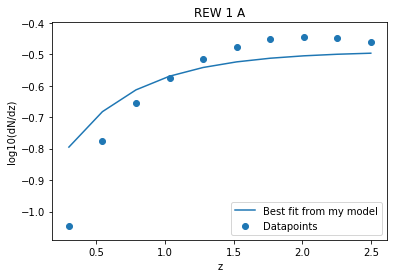

In [23]:
redshifts = np.linspace(0.3,2.5,10)
def scaled_dndz(red,a):
    return a*np.log10(ad.dNdz(red,0.1*u.nm).value)

g0 = 0.63
alpha_g = 5.38
z_g = 0.41
beta_g = 2.97
W0 = 0.33
alpha_W = 1.21
z_W = 2.24
beta_W = 2.43

dg0 = 0.39
dalpha_g = 1.08
dzg = 0.06
dbeta_g = 0.59
dW0 = 0.03
dalpha_w = 0.19
dz_w = 0.28
dbeta_w = 0.25

#And now the functions:
def g (z,g0,alpha_g,z_g,beta_g) :
    return g0*((1+z)**alpha_g)/(1+(z/z_g)**beta_g)
def Wstar (z,W0,alpha_W,z_W,beta_W):
    return W0*((1+z)**alpha_W)/(1+(z/z_W)**beta_W)
def zhu_dNdz (z, W,g0,alpha_g,z_g,beta_g,W0,alpha_W,z_W,beta_W) :
    return g(z,g0,alpha_g,z_g,beta_g)*Wstar(z,W0,alpha_W,z_W,beta_W)*np.exp(-W/Wstar(z,W0,alpha_W,z_W,beta_W))

datapoints = np.log10(zhu_dNdz(redshifts,1,g0,alpha_g,z_g,beta_g,W0,alpha_W,z_W,beta_W))
#pdb.set_trace()
#popt, pcov = curve_fit(scaled_dndz,redshifts,datapoints,p0=0.001)

fit_curve = [np.log10(0.0045*ad.dNdz(z,0.1*u.nm).value) for z in redshifts]
plt.figure()
plt.scatter(redshifts,datapoints,label="Datapoints")
plt.plot(redshifts,fit_curve,label="Best fit from my model")
plt.legend()
plt.xlabel("z")
plt.ylabel("log10(dN/dz)")
plt.title("REW 1 A")
plt.show()

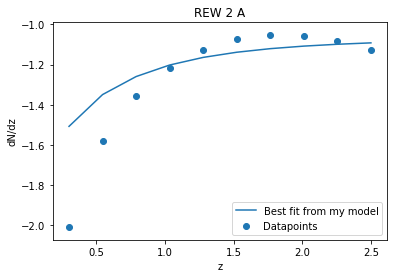

In [24]:
datapoints = np.log10(zhu_dNdz(redshifts,2))
#pdb.set_trace()
#popt, pcov = curve_fit(scaled_dndz,redshifts,datapoints,p0=0.001)

fit_curve = [np.log10(0.0015*ad.dNdz(z,0.2*u.nm).value) for z in redshifts]
plt.figure()
plt.scatter(redshifts,datapoints,label="Datapoints")
plt.plot(redshifts,fit_curve,label="Best fit from my model")
plt.legend()
plt.xlabel("z")
plt.ylabel("dN/dz")
plt.title("REW 2 A")
plt.show()

## Performance issues

In [16]:
cProfile.run("np.log(10)*quad(integrand,M_low,M_high)[0]")
#integral = np.log(10)*quad(integrand,M_low,M_high)[0]

         8975518 function calls (8898040 primitive calls) in 31.853 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    15450    0.031    0.000    0.073    0.000 <frozen importlib._bootstrap>:995(_handle_fromlist)
      147    0.012    0.000   31.852    0.217 <ipython-input-11-a947a44eeddb>:1(integrand)
        1    0.000    0.000   31.853   31.853 <string>:1(<module>)
      147    0.008    0.000    0.016    0.000 _fitpack_impl.py:317(splrep)
      147    0.003    0.000    0.008    0.000 _fitpack_impl.py:526(splev)
     6990    0.012    0.000    0.151    0.000 _methods.py:31(_sum)
   525306    0.478    0.000    0.478    0.000 _weakrefset.py:70(__contains__)
   331806    0.762    0.000    1.241    0.000 abc.py:178(__instancecheck__)
      147    0.003    0.000    0.004    0.000 const.py:27(initializecosmo)
      147    0.001    0.000    0.001    0.000 constant.py:139(__quantity_subclass__)
      441    0.000    0.000    0.00

    60975    0.144    0.000    0.213    0.000 six.py:580(iteritems)
     1323    0.005    0.000    0.005    0.000 transfunction.py:11(zeq)
      441    3.454    0.008    5.079    0.012 transfunction.py:111(Tbaryon)
      441    0.008    0.000    0.008    0.000 transfunction.py:120(Gfunc)
      441    0.043    0.000    8.502    0.019 transfunction.py:139(transfunction)
     2646    0.012    0.000    0.012    0.000 transfunction.py:19(keq)
     1323    0.011    0.000    0.011    0.000 transfunction.py:27(zdrag)
     2205    0.005    0.000    0.005    0.000 transfunction.py:39(ratiob2p)
      882    0.038    0.000    0.052    0.000 transfunction.py:47(soundhorizon)
      441    0.002    0.000    0.002    0.000 transfunction.py:60(ksilk)
      441    0.295    0.001    0.295    0.001 transfunction.py:70(j_0)
     1323    3.853    0.003    3.863    0.003 transfunction.py:77(Ttilde)
      441    0.777    0.002    3.380    0.008 transfunction.py:89(Tcdm)
    25641    0.217    0.000    0.486   

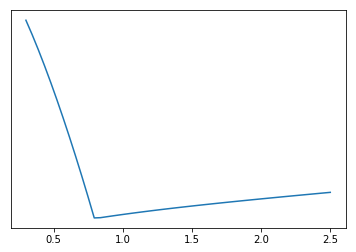

In [6]:
redshifts = np.linspace(0.3,2.5)
dndzlist = [ad.dNdz(z,rew_min=0.15*u.nm,rew_max=0.26*u.nm) for z in redshifts]
plt.semilogy(redshifts,dndzlist)
plt.show()

In [3]:
hmod.lowest_mass(rew=0.1*u.nm,z=1,low=3)

<Quantity 1749320.2255893906 solMass>

In [ ]:
hmod.rg(M=)